## IOU 

步骤1：按照得分的顺序将所有bounding box进行排序。。
步骤2：最高的那个肯定留下，然后计算它与其他所有bounding box（得分都低于他）的IoU（交并比，不解释了）。若某个bounding box的ioU小于设定的阈值，那就留下他，不然就删掉他。。
步骤3：余下的继续执行1~2步

In [3]:
import numpy as np
 
#  我们自定义数据： 数据格式是[[xmin,ymin,xmax,ymax,scores]....]
boxes=np.array([[100,100,210,210,0.72],
        [250,250,420,420,0.8],
        [220,220,320,330,0.92],
        [100,100,210,210,0.72],
        [230,240,325,330,0.81],
        [220,230,315,340,0.9]]) 

In [4]:
def py_cpu_nms(dets, thresh):
    #首先数据赋值和计算对应矩形框的面积
    #dets的数据格式是dets[[xmin,ymin,xmax,ymax,scores]....]
 
    x1 = dets[:,0] # 第一列
    y1 = dets[:,1]
    x2 = dets[:,2]
    y2 = dets[:,3]
    areas = (y2-y1+1) * (x2-x1+1) # 面积  左上右下的位置还可以，左下右上的就不对
    scores = dets[:,4]
    print('areas  ',areas)
    print('scores ',scores)
 
    #这边的keep用于存放，NMS后剩余的方框
    keep = []
    
    #取出分数从大到小排列的索引。.argsort()是从小到大排列，[::-1]是列表头和尾颠倒一下。
    index = scores.argsort()[::-1]
    print(index) 
    #上面这两句比如分数[0.72 0.8  0.92 0.72 0.81 0.9 ]    
    #  对应的索引index[  2   5    4     1    3   0  ]记住是取出索引，scores列表没变。
    
    #index会剔除遍历过的方框，和合并过的方框。 
    while index.size >0:
        print(index.size)
        #取出第一个方框进行和其他方框比对，看有没有可以合并的
        i = index[0]       # every time the first is the biggst, and add it directly
        
        #因为我们这边分数已经按从大到小排列了。
        #所以如果有合并存在，也是保留分数最高的这个，也就是我们现在那个这个
        #keep保留的是索引值，不是具体的分数。     
        keep.append(i) # 索引值，不是具体的分数。 
        print(keep)
        print('x1',x1[i])
        print(x1[index[1:]])
 
        #计算交集的左上角和右下角
        #这里要注意，比如x1[i]这个方框的左上角x和所有其他的方框的左上角x的
        x11 = np.maximum(x1[i], x1[index[1:]])    # calculate the points of overlap 
        y11 = np.maximum(y1[i], y1[index[1:]])
        x22 = np.minimum(x2[i], x2[index[1:]])
        y22 = np.minimum(y2[i], y2[index[1:]])
        
        print(x11,y11,x22,y22)
        #这边要注意，如果两个方框相交，X22-X11和Y22-Y11是正的。
        #如果两个方框不相交，X22-X11和Y22-Y11是负的，我们把不相交的W和H设为0.
        w = np.maximum(0, x22-x11+1)    
        h = np.maximum(0, y22-y11+1)    
       
        #计算重叠面积就是上面说的交集面积。不相交因为W和H都是0，所以不相交面积为0
        overlaps = w*h
        print('overlaps is',overlaps)
        
        #这个就是IOU公式（交并比）。
        #得出来的ious是一个列表，里面拥有当前方框和其他所有方框的IOU结果。
        ious = overlaps / (areas[i]+areas[index[1:]] - overlaps)
        print('ious is',ious)
        
        #接下来是合并重叠度最大的方框，也就是合并ious中值大于thresh的方框
        #我们合并的操作就是把他们剔除，因为我们合并这些方框只保留下分数最高的。
        #我们经过排序当前我们操作的方框就是分数最高的，所以我们剔除其他和当前重叠度最高的方框
        #这里np.where(ious<=thresh)[0]是一个固定写法。
        idx = np.where(ious<=thresh)[0]
        print(idx)
 
        #把留下来框在进行NMS操作
        #这边留下的框是去除当前操作的框，和当前操作的框重叠度大于thresh的框
        #每一次都会先去除当前操作框，所以索引的列表就会向前移动移位，要还原就+1，向后移动一位
        index = index[idx+1]   # because index start from 1
        print(index)
    return keep # 

areas   [12321. 29241. 11211. 12321.  8736. 10656.]
scores  [0.72 0.8  0.92 0.72 0.81 0.9 ]
[2 5 4 1 3 0]
6
[2]
x1 220.0
[220. 230. 250. 100. 100.]
[220. 230. 250. 220. 220.] [230. 240. 250. 220. 220.] [315. 320. 320. 210. 210.] [330. 330. 330. 210. 210.]
overlaps is [9696. 8281. 5751.    0.    0.]
ious is [0.79664777 0.70984056 0.16573009 0.         0.        ]
[2 3 4]
[1 3 0]
3
[2, 1]
x1 250.0
[100. 100.]
[250. 250.] [250. 250.] [210. 210.] [210. 210.]
overlaps is [0. 0.]
ious is [0. 0.]
[0 1]
[3 0]
2
[2, 1, 3]
x1 100.0
[100.]
[100.] [100.] [210.] [210.]
overlaps is [12321.]
ious is [1.]
[]
[]


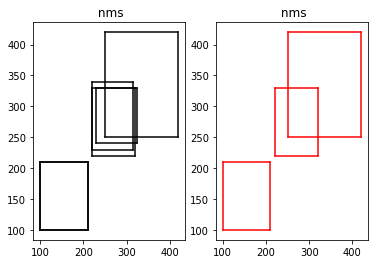

In [6]:
# 运行并可视化
 
import matplotlib.pyplot as plt
# 可视化
def plot_bbox(dets, c='k'):
    x1 = dets[:,0]
    y1 = dets[:,1]
    x2 = dets[:,2]
    y2 = dets[:,3]
    
    plt.plot([x1,x2], [y1,y1], c)
    plt.plot([x1,x1], [y1,y2], c)
    plt.plot([x1,x2], [y2,y2], c)
    plt.plot([x2,x2], [y1,y2], c)
    plt.title(" nms")
 
    
plt.figure(1)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
 
plt.sca(ax1)
plot_bbox(boxes,'k')   # before nms
 
keep = py_cpu_nms(boxes, thresh=0.7) # 输入boxes==============================================
plt.sca(ax2)
plot_bbox(boxes[keep], 'r')# after nms

plt.show() # 显示图像